下面几段代码展示朴素贝叶斯模型的训练和预测。这里使用的数据集为本书自制的Books数据集，包含约1万本图书的标题，分为3种主题。首先是预处理，针对文本分类的预处理主要包含以下步骤：

- 通常可以将英文文本全部转换为小写，或者将中文内容全部转换为简体，等等，这一般不会改变文本内容。
- 去除标点。英文中的标点符号和单词之间没有空格（如——“Hi, there!”），如果不去除标点，“Hi,”和“there!”会被识别为不同于“Hi”和“there”的两个词，这显然是不合理的。对于中文，移除标点一般也不会影响文本的内容。
- 分词。中文汉字之间没有空格分隔，中文分词有时比英文分词更加困难，此处不再赘述。
- 去除停用词（如“I”、“is”、“的”等）。这些词往往大量出现但没有具体含义。
- 建立词表。通常会忽略语料库中频率非常低的词。
- 将词转换为词表索引（ID），便于机器学习模型使用。

In [1]:
import json
import os
import requests
import re
from tqdm import tqdm
from collections import defaultdict
from string import punctuation
import spacy
from spacy.lang.zh.stop_words import STOP_WORDS
nlp = spacy.load('zh_core_web_sm')


class BooksDataset:
    def __init__(self):
        train_file, test_file = 'train.jsonl', 'test.jsonl'

        # 下载数据为JSON格式，转化为Python对象
        def read_file(file_name):
            with open(file_name, 'r', encoding='utf-8') as fin:
                json_list = list(fin)
            data_split = []
            for json_str in json_list:
                data_split.append(json.loads(json_str))
            return data_split

        self.train_data, self.test_data = read_file(train_file),\
            read_file(test_file)
        print('train size =', len(self.train_data), 
              ', test size =', len(self.test_data))
        
        # 建立文本标签和数字标签的映射
        self.label2id, self.id2label = {}, {}
        for data_split in [self.train_data, self.test_data]:
            for data in data_split:
                txt = data['class']
                if txt not in self.label2id:
                    idx = len(self.label2id)
                    self.label2id[txt] = idx
                    self.id2label[idx] = txt
                label_id = self.label2id[txt]
                data['label'] = label_id

    def tokenize(self, attr='book'):
        # 使用以下两行命令安装spacy用于中文分词
        # pip install -U spacy
        # python -m spacy download zh_core_web_sm
        # 去除文本中的符号和停用词
        for data_split in [self.train_data, self.test_data]:
            for data in tqdm(data_split):
                # 转为小写
                text = data[attr].lower()
                # 符号替换为空
                tokens = [t.text for t in nlp(text) \
                    if t.text not in STOP_WORDS]
                # 这一步比较耗时，因此把tokenize的结果储存起来
                data['tokens'] = tokens

    # 根据分词结果建立词表，忽略部分低频词，
    # 可以设置词最短长度和词表最大大小
    def build_vocab(self, min_freq=3, min_len=2, max_size=None):
        frequency = defaultdict(int)
        for data in self.train_data:
            tokens = data['tokens']
            for token in tokens:
                frequency[token] += 1 

        print(f'unique tokens = {len(frequency)}, '+\
              f'total counts = {sum(frequency.values())}, '+\
              f'max freq = {max(frequency.values())}, '+\
              f'min freq = {min(frequency.values())}')    

        self.token2id = {}
        self.id2token = {}
        total_count = 0
        for token, freq in sorted(frequency.items(),\
            key=lambda x: -x[1]):
            if max_size and len(self.token2id) >= max_size:
                break
            if freq > min_freq:
                if (min_len is None) or (min_len and \
                    len(token) >= min_len):
                    self.token2id[token] = len(self.token2id)
                    self.id2token[len(self.id2token)] = token
                    total_count += freq
            else:
                break
        print(f'min_freq = {min_freq}, min_len = {min_len}, '+\
              f'max_size = {max_size}, '
              f'remaining tokens = {len(self.token2id)}, '
              f'in-vocab rate = {total_count / sum(frequency.values())}')

    # 将分词后的结果转化为数字索引
    def convert_tokens_to_ids(self):
        for data_split in [self.train_data, self.test_data]:
            for data in data_split:
                data['token_ids'] = []
                for token in data['tokens']:
                    if token in self.token2id:
                        data['token_ids'].append(self.token2id[token])

        
dataset = BooksDataset()
dataset.tokenize()
print(dataset.train_data[0]['tokens'])
print(dataset.label2id)

train size = 8627 , test size = 2157


100%|██████████| 2157/2157 [00:11<00:00, 180.64it/s]

['python', '编程', '入门', '教程']
{'计算机类': 0, '艺术传媒类': 1, '经管类': 2}


完成分词后，对出现次数超过3次的词元建立词表，并将分词后的文档转化为词元id的序列。

In [2]:
dataset.build_vocab(min_freq=3)
dataset.convert_tokens_to_ids()
print(dataset.train_data[0]['token_ids'])

unique tokens = 6956, total counts = 54884, max freq = 1635, min freq = 1
min_freq = 3, min_len = 2, max_size = None, remaining tokens = 1650,
 in-vocab rate = 0.7944209605713869
[18, 26, 5, 0]


接下来将数据和标签准备成便于训练的矩阵格式。

In [3]:
import numpy as np

train_X, train_Y = [], []
test_X, test_Y = [], []

for data in dataset.train_data:
    x = np.zeros(len(dataset.token2id), dtype=np.int32)
    for token_id in data['token_ids']:
        x[token_id] += 1
    train_X.append(x)
    train_Y.append(data['label'])
for data in dataset.test_data:
    x = np.zeros(len(dataset.token2id), dtype=np.int32)
    for token_id in data['token_ids']:
        x[token_id] += 1
    test_X.append(x)
    test_Y.append(data['label'])
train_X, train_Y = np.array(train_X), np.array(train_Y)
test_X, test_Y = np.array(test_X), np.array(test_Y)

下面代码展示朴素贝叶斯的训练和预测。

In [4]:
import numpy as np

class NaiveBayes:
    def __init__(self, num_classes, vocab_size):
        self.num_classes = num_classes
        self.vocab_size = vocab_size
        self.prior = np.zeros(num_classes, dtype=np.float64)
        self.likelihood = np.zeros((num_classes, vocab_size),\
            dtype=np.float64)
        
    def fit(self, X, Y):
        # NaiveBayes的训练主要涉及先验概率和似然的估计，
        # 这两者都可以通过计数简单获得
        for x, y in zip(X, Y):
            self.prior[y] += 1
            for token_id in x:
                self.likelihood[y, token_id] += 1
                
        self.prior /= self.prior.sum()
        # laplace平滑
        self.likelihood += 1
        self.likelihood /= self.likelihood.sum(axis=0)
        # 为了避免精度溢出，使用对数概率
        self.prior = np.log(self.prior)
        self.likelihood = np.log(self.likelihood)
    
    def predict(self, X):
        # 算出各个类别的先验概率与似然的乘积，找出最大的作为分类结果
        preds = []
        for x in X:
            p = np.zeros(self.num_classes, dtype=np.float64)
            for i in range(self.num_classes):
                p[i] += self.prior[i]
                for token in x:
                    p[i] += self.likelihood[i, token]
            preds.append(np.argmax(p))
        return preds

nb = NaiveBayes(len(dataset.label2id), len(dataset.token2id))
train_X, train_Y = [], []
for data in dataset.train_data:
    train_X.append(data['token_ids'])
    train_Y.append(data['label'])
nb.fit(train_X, train_Y)

for i in range(3):
    print(f'P({dataset.id2label[i]}) = {np.exp(nb.prior[i])}')
for i in range(3):
    print(f'P({dataset.id2token[i]}|{dataset.id2label[0]}) = '+\
          f'{np.exp(nb.likelihood[0, i])}')

test_X, test_Y = [], []
for data in dataset.test_data:
    test_X.append(data['token_ids'])
    test_Y.append(data['label'])
    
NB_preds = nb.predict(test_X)
    
for i, (p, y) in enumerate(zip(NB_preds, test_Y)):
    if i >= 5:
        break
    print(f'test example-{i}, prediction = {p}, label = {y}')

P(计算机类) = 0.4453460067230787
P(艺术传媒类) = 0.26660484525327466
P(经管类) = 0.2880491480236467
P(教程|计算机类) = 0.5726495726495726
P(基础|计算机类) = 0.6503006012024048
P(设计|计算机类) = 0.606694560669456
test example-0, prediction = 0, label = 0
test example-1, prediction = 0, label = 0
test example-2, prediction = 1, label = 1
test example-3, prediction = 1, label = 1
test example-4, prediction = 1, label = 1


下面使用第3章介绍的TF-IDF方法得到文档的特征向量，并使用PyTorch实现逻辑斯谛回归模型的训练和预测。

In [5]:
import os
import sys

sys.path.append('../code')
from utils import TFIDF
        
tfidf = TFIDF(len(dataset.token2id))
tfidf.fit(train_X)
train_F = tfidf.transform(train_X)
test_F = tfidf.transform(test_X)

逻辑斯谛回归可以看作一个一层的神经网络模型，使用PyTorch实现可以方便地利用自动求导功能。

epoch-49, loss=0.2376: 100%|█| 50/50 [00:09<00:00,  5.36it/s


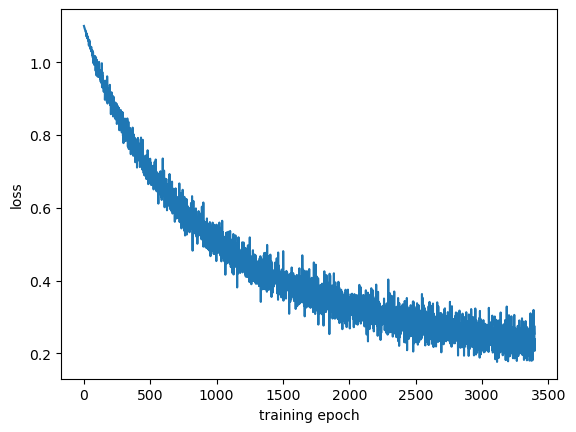

eval_loss = 0.2869


In [6]:
import torch
from torch import nn

class LR(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LR, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, input_feats, labels=None):
        outputs = self.linear(input_feats)
        
        if labels is not None:
            loss_fc = nn.CrossEntropyLoss()
            loss = loss_fc(outputs, labels)
            return (loss, outputs)
        
        return outputs

model = LR(len(dataset.token2id), len(dataset.label2id))

from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam

# 使用PyTorch的DataLoader来进行数据循环，因此按照PyTorch的接口
# 实现myDataset和DataCollator两个类
# myDataset是对特征向量和标签的简单封装便于对齐接口，
# DataCollator用于批量将数据转化为PyTorch支持的张量类型
class myDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (self.X[idx], self.Y[idx])

class DataCollator:
    @classmethod
    def collate_batch(cls, batch):
        feats, labels = [], []
        for x, y in batch:
            feats.append(x)
            labels.append(y)
        # 直接将一个ndarray的列表转化为张量是非常慢的，
        # 所以需要提前将列表转化为一整个ndarray
        feats = torch.tensor(np.array(feats), dtype=torch.float)
        labels = torch.tensor(np.array(labels), dtype=torch.long)
        return {'input_feats': feats, 'labels': labels}

# 设置训练超参数和优化器，模型初始化
epochs = 50
batch_size = 128
learning_rate = 1e-3
weight_decay = 0

train_dataset = myDataset(train_F, train_Y)
test_dataset = myDataset(test_F, test_Y)

data_collator = DataCollator()
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,\
    shuffle=True, collate_fn=data_collator.collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,\
    shuffle=False, collate_fn=data_collator.collate_batch)
optimizer = Adam(model.parameters(), lr=learning_rate,\
    weight_decay=weight_decay)
model.zero_grad()
model.train()

from tqdm import tqdm, trange
import matplotlib.pyplot as plt

# 模型训练
with trange(epochs, desc='epoch', ncols=60) as pbar:
    epoch_loss = []
    for epoch in pbar:
        model.train()
        for step, batch in enumerate(train_dataloader):
            loss = model(**batch)[0]
            pbar.set_description(f'epoch-{epoch}, loss={loss.item():.4f}')
            loss.backward()
            optimizer.step()
            model.zero_grad()
            epoch_loss.append(loss.item())

    epoch_loss = np.array(epoch_loss)
    # 打印损失曲线
    plt.plot(range(len(epoch_loss)), epoch_loss)
    plt.xlabel('training epoch')
    plt.ylabel('loss')
    plt.show()
    
    model.eval()
    with torch.no_grad():
        loss_terms = []
        for batch in test_dataloader:
            loss = model(**batch)[0]
            loss_terms.append(loss.item())
        print(f'eval_loss = {np.mean(loss_terms):.4f}')

下面的代码使用训练好的模型对测试集进行预测，并报告分类结果。

In [7]:
LR_preds = []
model.eval()
for batch in test_dataloader:
    with torch.no_grad():
        _, preds = model(**batch)
        preds = np.argmax(preds, axis=1)
        LR_preds.extend(preds)
            
for i, (p, y) in enumerate(zip(LR_preds, test_Y)):
    if i >= 5:
        break
    print(f'test example-{i}, prediction = {p}, label = {y}')

test example-0, prediction = 0, label = 0
test example-1, prediction = 0, label = 0
test example-2, prediction = 1, label = 1
test example-3, prediction = 1, label = 1
test example-4, prediction = 1, label = 1


下面的代码展示多分类情况下宏平均和微平均的算法。

In [8]:
test_Y = np.array(test_Y)
NB_preds = np.array(NB_preds)
LR_preds = np.array(LR_preds)

def micro_f1(preds, labels):
    TP = np.sum(preds == labels)
    FN = FP = 0
    for i in range(len(dataset.label2id)):
        FN += np.sum((preds == i) & (labels != i))
        FP += np.sum((preds != i) & (labels == i))
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    return f1

def macro_f1(preds, labels):
    f_scores = []
    for i in range(len(dataset.label2id)):
        TP = np.sum((preds == i) & (labels == i))
        FN = np.sum((preds == i) & (labels != i))
        FP = np.sum((preds != i) & (labels == i))
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * precision * recall / (precision + recall)
        f_scores.append(f1)
    return np.mean(f_scores)

print(f'NB: micro-f1 = {micro_f1(NB_preds, test_Y)}, '+\
      f'macro-f1 = {macro_f1(NB_preds, test_Y)}')
print(f'LR: micro-f1 = {micro_f1(LR_preds, test_Y)}, '+\
      f'macro-f1 = {macro_f1(LR_preds, test_Y)}')

NB: micro-f1 = 0.8961520630505331, macro-f1 = 0.8948572078813896
LR: micro-f1 = 0.914696337505795, macro-f1 = 0.9139442964719672
